# Imports

In [1]:
import numpy as np
np.random.seed(2)
import random
random.seed(1)

In [2]:
import os
import pandas as pd
from matplotlib import pyplot as plt
%matplotlib inline
from importances import importances

In [3]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold
from evolutionary_search import EvolutionaryAlgorithmSearchCV
from sklearn.metrics import mean_squared_error

In [4]:
if not os.path.exists('results'):
    os.makedirs('results')

# Gradient Boosting

In [5]:
clf = GradientBoostingRegressor(random_state=2)
clf

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=2,
             subsample=1.0, verbose=0, warm_start=False)

In [6]:
train = pd.read_csv('../feature_engineering/train.gz')
X_train = train[train.columns[:-1]].values
y_train = train[train.columns[-1]].values

In [7]:
test = pd.read_csv('../feature_engineering/test.gz')
X_test = test[test.columns[:-1]].values
y_test = test[test.columns[-1]].values

## Grid Search

In [8]:
cv = KFold(n_splits=3, shuffle=True, random_state=2)
cv

KFold(n_splits=3, random_state=2, shuffle=True)

In [9]:
params = {
    "learning_rate": [0.8, 0.5, 0.3, 0.2, 0.1, 0.01, 0.001],
    "n_estimators": [1 + 2*x for x in range(1, 12)],
    "max_features": ["sqrt", "log2", None],
    "max_depth": [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    "min_samples_split": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "min_samples_leaf": [2, 3, 4, 5, 6, 7, 8, 9, 10],
    "max_leaf_nodes": [2, 5, 10, 50, 100, None],
    "min_impurity_decrease": [0, 0.001, 0.01, 0.1, 0.2, 0.3, 0.4],
}

In [10]:
grid = EvolutionaryAlgorithmSearchCV(
    estimator=clf, 
    params=params, 
    cv=cv, 
    scoring='neg_mean_squared_error',
    n_jobs=4, 
    population_size=10,
    gene_mutation_prob=0.10,
    gene_crossover_prob=0.5,
    tournament_size=3,
    generations_number=15,
    verbose=1,
)
grid

EvolutionaryAlgorithmSearchCV(cv=KFold(n_splits=3, random_state=2, shuffle=True),
               error_score='raise',
               estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, presort='auto', random_state=2,
             subsample=1.0, verbose=0, warm_start=False),
               fit_params={}, gene_crossover_prob=0.5,
               gene_mutation_prob=0.1, gene_type=None,
               generations_number=15, iid=True, n_jobs=4,
               params={'learning_rate': [0.8, 0.5, 0.3, 0.2, 0.1, 0.01, 0.001], 'n_estimators': [3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23], 'max_features': ['sqrt', 'log2', None], 'max_depth': [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 

In [11]:
_ = grid.fit(X_train, y_train)

Types [2, 1, 1, 1, 1, 1, 1, 1] and maxint [6, 10, 2, 11, 8, 8, 5, 6] detected
--- Evolve in 9430344 possible combinations ---
gen	nevals	avg    	min     	max     	std    
0  	10    	-114.03	-270.414	-24.1733	79.9495
1  	7     	-54.8782	-136.465	-24.1495	31.3542
2  	4     	-30.9377	-59.9528	-24.1495	11.5469
3  	7     	-24.0619	-24.1733	-23.2023	0.286753
4  	7     	-23.8677	-24.1733	-23.2023	0.435699
5  	6     	-23.3958	-24.1495	-20.4014	1.09347 
6  	5     	-22.2714	-24.1495	-20.4014	1.56552 
7  	7     	-21.2417	-23.2023	-20.4014	1.28352 
8  	6     	-20.5388	-21.7756	-20.4014	0.41227 
9  	6     	-20.5431	-21.8183	-20.4014	0.425076
10 	6     	-20.4014	-20.4014	-20.4014	3.55271e-15
11 	4     	-20.4014	-20.4014	-20.4014	3.55271e-15
12 	5     	-20.4014	-20.4014	-20.4014	3.55271e-15
13 	5     	-20.4014	-20.4014	-20.4014	3.55271e-15
14 	6     	-20.2089	-20.4014	-18.9935	0.433462   
15 	3     	-19.9897	-20.508 	-18.9935	0.652914   
Best individual is: {'learning_rate': 0.3, 'n_estimators': 21, 

In [12]:
best = pd.Series(grid.best_params_)
best.to_csv('results/gb-params.csv')
best

learning_rate              0.3
max_depth                 10.0
max_features               NaN
max_leaf_nodes           100.0
min_impurity_decrease      0.2
min_samples_leaf           9.0
min_samples_split          3.0
n_estimators              21.0
dtype: float64

In [13]:
results = grid.cv_results_
df = pd.DataFrame(results)
df.to_csv('results/gb-grid.csv')
df

,index,max_test_score,mean_test_score,min_test_score,nan_test_score?,param_index,params,std_test_score
0,11,-24.173330,-24.173330,-24.173330,False,0,"{'learning_rate': 0.5, 'n_estimators': 21, 'ma...",0.0
1,12,-136.465148,-136.465148,-136.465148,False,0,"{'learning_rate': 0.2, 'n_estimators': 19, 'ma...",0.0
2,13,-59.952810,-59.952810,-59.952810,False,0,"{'learning_rate': 0.2, 'n_estimators': 19, 'ma...",0.0
3,14,-59.952810,-59.952810,-59.952810,False,0,"{'learning_rate': 0.2, 'n_estimators': 19, 'ma...",0.0
4,15,-40.153275,-40.153275,-40.153275,False,0,"{'learning_rate': 0.3, 'n_estimators': 19, 'ma...",0.0
5,16,-59.952810,-59.952810,-59.952810,False,0,"{'learning_rate': 0.2, 'n_estimators': 19, 'ma...",0.0
6,18,-59.952810,-59.952810,-59.952810,False,0,"{'learning_rate': 0.2, 'n_estimators': 19, 'ma...",0.0
7,19,-24.173330,-24.173330,-24.173330,False,0,"{'learning_rate': 0.5, 'n_estimators': 21, 'ma...",0.0
8,20,-24.173330,-24.173330,-24.173330,False,0,"{'learning_rate': 0.5, 'n_estimators': 21, 'ma...",0.0
9,21,-24.149531,-24.149531,-24.149531,False,0,"{'learning_rate': 0.5, 'n_estimators': 21, 'ma...",0.0


# Testing

In [14]:
clf = GradientBoostingRegressor(**grid.best_params_)
clf

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=100, min_impurity_decrease=0.2,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=21, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [15]:
clf.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.3, loss='ls', max_depth=10, max_features=None,
             max_leaf_nodes=100, min_impurity_decrease=0.2,
             min_impurity_split=None, min_samples_leaf=9,
             min_samples_split=3, min_weight_fraction_leaf=0.0,
             n_estimators=21, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

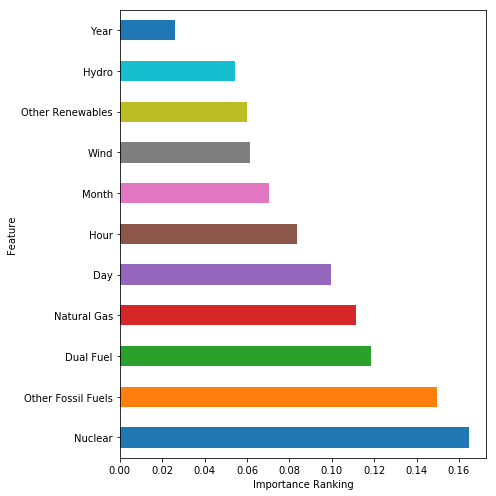

In [16]:
_ = importances(clf, train[train.columns[:-1]])
plt.savefig('results/gb-importances.pdf')
plt.savefig('results/gb-importances.svg')

## Training Accuracy

In [17]:
train_pred = clf.predict(X_train)

In [18]:
train_err = mean_squared_error(y_train, train_pred)
train_err

7.167487051021255

In [19]:
train_df = pd.DataFrame([y_train, train_pred], index=['Truth', 'Predictions']).T

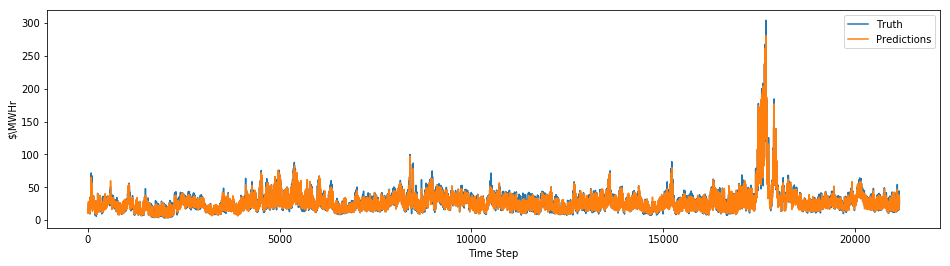

In [20]:
ax = train_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/gb-train.pdf')
plt.savefig('results/gb-train.svg')

## Testing Accuracy

In [21]:
test_pred = clf.predict(X_test)

In [22]:
test_err = mean_squared_error(y_test, test_pred)
test_err

35.399130185616784

In [23]:
test_df = pd.DataFrame([y_test, test_pred], index=['Truth', 'Predictions']).T

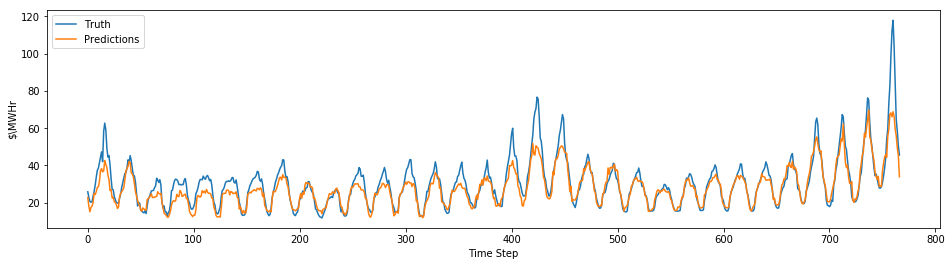

In [24]:
ax = test_df.plot(figsize=(16, 4))
ax.set_ylabel('$\MWHr')
ax.set_xlabel('Time Step')
plt.savefig('results/gb-test.pdf')
plt.savefig('results/gb-test.svg')

## Results

In [25]:
results = pd.Series([train_err, test_err], index=['Train', 'Test'])
results

Train     7.167487
Test     35.399130
dtype: float64

In [26]:
results.to_csv('results/gb-mse.csv')